In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
# from snowflake.connector.pandas_tools import write_pandas
# from sqlalchemy import create_engine

import json
from tqdm import tqdm
import os

from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

from datetime import datetime

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# df_full_card_events = pd.DataFrame(columns=['MATCH_ID', 'PERIOD_ID', 'TIME_SECONDS', 'NEW_TIME_SECONDS', 'ORIGINAL_EVENT_ID',
#                                             'TEAM_WS_ID', 'PLAYER_WS_ID', 'CARD_TYPE'])
# df_full_sub_events = pd.DataFrame(columns=['MATCH_ID', 'PERIOD_ID', 'TIME_SECONDS', 'NEW_TIME_SECONDS', 'ORIGINAL_EVENT_ID',
#                                             'TEAM_WS_ID', 'PLAYER_WS_ID_ON', 'PLAYER_WS_ID_OFF'])

# matches_loc = r"D:\soccerdata_dump\data\WhoScored\events\ITA-Serie A_2324"
# match_list = os.listdir(matches_loc)
# for _match in tqdm(match_list):
#     match_id = int(_match.split(".")[0])
#     with open(matches_loc + "\\" + _match, 'r') as file:
#         data = json.load(file)
#         df_events = pd.DataFrame(data['events'])
#         try:
#             card_events = df_events[df_events['cardType'].notna()]
#             subs_off = df_events[df_events['type'] == {'displayName': 'SubstitutionOff', 'value': 18}]
#             subs_on = df_events[df_events['type'] == {'displayName': 'SubstitutionOn', 'value': 19}]
#             subs_off.reset_index(drop=True, inplace=True)
#             subs_on.reset_index(drop=True, inplace=True)
#             for index, row in card_events.iterrows():
#                 card_entry = [match_id, row['period']['value'], row['minute']*60 + row['second'], 
#                               row['expandedMinute']*60 + row['second'], row['id'], row['teamId'], row['playerId'], 
#                               row['cardType']['displayName']]
#                 df_full_card_events = pd.concat([df_full_card_events, pd.DataFrame([card_entry], 
#                                                     columns = df_full_card_events.columns)], ignore_index=True)
#             if len(subs_on) != len(subs_off):
#                 raise ValueError("Subs on and off mismatch")
#             for index, row in subs_off.iterrows():
#                 sub_entry = [match_id, row['period']['value'], row['minute']*60 + row['second'], 
#                               row['expandedMinute']*60 + row['second'], row['id'], row['teamId'], subs_on.loc[index]['playerId'], 
#                               subs_off.loc[index]['playerId']]
#                 df_full_sub_events = pd.concat([df_full_sub_events, pd.DataFrame([sub_entry], 
#                                                     columns = df_full_sub_events.columns)], ignore_index=True)
#         except:
#             print("No card events in " + _match)

# df_full_card_events.to_csv("card_events.csv", index=False)
# df_full_sub_events.to_csv("sub_events.csv", index=False)

In [4]:
# def upsert_to_snowflake(table_name, dataframe, primary_keys):
#     if isinstance(primary_keys, str):
#         primary_keys = [primary_keys]

#     temp_table_name = f"{table_name}_TEMP"
#     success, nchunks, nrows, _ = write_pandas(conn, dataframe, temp_table_name, auto_create_table=True)

#     on_condition = ' AND '.join([f"{table_name}.{pk} = {temp_table_name}.{pk}" for pk in primary_keys])

#     update_columns = [col for col in dataframe.columns if col not in primary_keys]
#     update_sql = ', '.join([f"{table_name}.{col} = {temp_table_name}.{col}" for col in update_columns])

#     merge_sql = f"""
#     MERGE INTO {table_name} USING {temp_table_name}
#     ON {on_condition}
#     """

#     if update_columns:
#         merge_sql += f"""
#         WHEN MATCHED THEN
#             UPDATE SET
#                 {update_sql}
#         """

#     merge_sql += f"""
#     WHEN NOT MATCHED THEN
#         INSERT ({', '.join(dataframe.columns)})
#         VALUES ({', '.join([f"{temp_table_name}.{col}" for col in dataframe.columns])})
#     """

#     cur.execute(merge_sql)
#     cur.execute(f"DROP TABLE IF EXISTS {temp_table_name}")

#     print(f"Upsert completed. {nrows} rows processed.")

In [5]:
# create_table_query = """
# CREATE TABLE IF NOT EXISTS CARDS (
#     MATCH_ID VARCHAR(255),
#     PERIOD_ID INT,
#     TIME_SECONDS FLOAT,
#     NEW_TIME_SECONDS FLOAT,
#     ORIGINAL_EVENT_ID INT,
#     TEAM_WS_ID INT,
#     PLAYER_WS_ID INT,
#     CARD_TYPE VARCHAR(255),
#     PRIMARY KEY (MATCH_ID, ORIGINAL_EVENT_ID),
#     FOREIGN KEY (MATCH_ID) REFERENCES GEGENSTATS.TABLES.MATCHES(MATCH_ID),
#     FOREIGN KEY (PLAYER_WS_ID) REFERENCES GEGENSTATS.TABLES.PLAYERS(PLAYER_WS_ID)
# );
# """

In [6]:
# cur.execute(create_table_query)

In [7]:
# upsert_to_snowflake("CARDS", df_full_card_events, ['MATCH_ID', 'ORIGINAL_EVENT_ID'])

In [8]:
# create_table_query = """
# CREATE TABLE IF NOT EXISTS SUBS (
#     MATCH_ID VARCHAR(255),
#     PERIOD_ID INT,
#     TIME_SECONDS FLOAT,
#     NEW_TIME_SECONDS FLOAT,
#     ORIGINAL_EVENT_ID INT,
#     TEAM_WS_ID INT,
#     PLAYER_WS_ID_ON INT,
#     PLAYER_WS_ID_OFF INT,
#     PRIMARY KEY (MATCH_ID, ORIGINAL_EVENT_ID),
#     FOREIGN KEY (MATCH_ID) REFERENCES GEGENSTATS.TABLES.MATCHES(MATCH_ID),
#     FOREIGN KEY (PLAYER_WS_ID_ON) REFERENCES GEGENSTATS.TABLES.PLAYERS(PLAYER_WS_ID),
#     FOREIGN KEY (PLAYER_WS_ID_OFF) REFERENCES GEGENSTATS.TABLES.PLAYERS(PLAYER_WS_ID)
# );
# """

In [9]:
# cur.execute(create_table_query)

In [10]:
# upsert_to_snowflake("SUBS", df_full_sub_events, ['MATCH_ID', 'ORIGINAL_EVENT_ID'])

In [11]:
# with open(matches_loc + "\\" + _match, 'r') as file:
#     data = json.load(file)
#     df_events = pd.DataFrame(data['events'])
#     card_events = df_events[df_events['cardType'].notna()]
#     for index, row in card_events.iterrows():
#         entry = [match_id, row['period']['value'], row['minute']*60 + row['second'], row['expandedMinute']*60 + row['second'], 
#                 row['id'], row['teamId'], row['playerId'], row['cardType']['value']]
#         df_full_card_events = pd.concat([df_full_card_events, pd.DataFrame([entry], columns = df_full_card_events.columns)], ignore_index=True)

In [12]:
# for index, row in card_events.iloc[[0]].iterrows():
#     entry = [match_id, row['period']['value'], row['minute']*60 + row['second'], row['expandedMinute']*60 + row['second'], 
#                 row['id'], row['teamId'], row['playerId'], row['cardType']['value']]
    

In [13]:
# df_full_card_events.add(pd.DataFrame([entry], columns = df_full_card_events.columns))

In [14]:
# df_full_card_events = pd.concat([df_full_card_events, pd.DataFrame([entry], columns = df_full_card_events.columns)], ignore_index=True)

In [16]:
## Import snowflake connection
import snowflake.connector

In [17]:
## Set options to view all columns
pd.set_option('display.max_columns', None)

In [18]:
SNOWFLAKE_USER = 'karan14'
SNOWFLAKE_PASSWORD = 'Snowfl@key0014'
SNOWFLAKE_ACCOUNT = 'lv65293.ca-central-1.aws'
SNOWFLAKE_WAREHOUSE = 'COMPUTE_WH'
SNOWFLAKE_DATABASE = 'GEGENSTATS'
SNOWFLAKE_SCHEMA = 'TABLES'

In [19]:
conn = snowflake.connector.connect(
    user=SNOWFLAKE_USER,
    password=SNOWFLAKE_PASSWORD,
    account=SNOWFLAKE_ACCOUNT,
    warehouse=SNOWFLAKE_WAREHOUSE,
    database=SNOWFLAKE_DATABASE,
    schema=SNOWFLAKE_SCHEMA
)

In [20]:
cursor = conn.cursor()

In [21]:
def fetch_data(cursor, query):
    cursor.execute(query)
    rows = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]
    return pd.DataFrame(rows, columns=column_names)

In [22]:
df_matches = fetch_data(cursor, 'SELECT * FROM MATCHES')

In [23]:
df_matches[df_matches['WS_MATCH_ID'] == 1729550]

,MATCH_ID,DATE_TIME,HOME_TEAM_ID,AWAY_TEAM_ID,COMPETITION,SEASON,STADIUM,GAMEWEEK,DAY,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,HOME_TEAM_XG,AWAY_TEAM_XG,ATTENDANCE,REFEREE,WS_MATCH_ID
5373,4b7e6f44,2023-12-03 14:00:00,822bd0ba,fd962109,ENG-Premier League,2324,Anfield,14,Sun,4,3,2.1,1.2,50124.0,Stuart Attwell,1729550


In [24]:
team_names = fetch_data(cursor, 'SELECT * FROM TEAMS')

In [25]:
df_matches = df_matches.merge(team_names[['TEAM_FBREF_ID', 'TEAM_NAME']].rename({'TEAM_FBREF_ID':'HOME_TEAM_ID',
                                   'TEAM_NAME':'HOME_TEAM_NAME'}, axis=1), on='HOME_TEAM_ID', how='left')

In [26]:
df_matches = df_matches.merge(team_names[['TEAM_FBREF_ID', 'TEAM_NAME']].rename({'TEAM_FBREF_ID':'AWAY_TEAM_ID',
                                   'TEAM_NAME':'AWAY_TEAM_NAME'}, axis=1), on='AWAY_TEAM_ID', how='left')

In [27]:
df_events = fetch_data(cursor, "SELECT * FROM EVENTS_SPADL WHERE MATCH_ID = '3e33bd98'")
df_player_match = fetch_data(cursor, "SELECT * FROM PLAYER_MATCH WHERE MATCH_ID = '3e33bd98'")
match_oi = df_matches[df_matches['MATCH_ID'] == '3e33bd98']

In [28]:
df_events = df_events.merge(df_player_match[['PLAYER_WS_ID', 'PLAYER_FBREF_NAME', 'MATCH_ID']], on=['PLAYER_WS_ID', 'MATCH_ID'])

In [29]:
df_events = df_events.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")

In [30]:
match_oi

,MATCH_ID,DATE_TIME,HOME_TEAM_ID,AWAY_TEAM_ID,COMPETITION,SEASON,STADIUM,GAMEWEEK,DAY,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,HOME_TEAM_XG,AWAY_TEAM_XG,ATTENDANCE,REFEREE,WS_MATCH_ID,HOME_TEAM_NAME,AWAY_TEAM_NAME
54,3e33bd98,2024-05-19 16:00:00,18bb7c10,d3fd31cc,ENG-Premier League,2324,Emirates Stadium,38,Sun,2,1,2.9,0.6,60312.0,Michael Oliver,1729408,Arsenal,Everton


In [31]:
df_successful_events = df_events[df_events['RESULT_ID'] == 1]

In [32]:
df_successful_in_play_events = df_successful_events[df_successful_events['TYPE_NAME'].isin(['pass', 
                                                                'dribble', 'clearance', 'cross'])]
df_successful_set_piece_events = df_successful_events[df_successful_events['TYPE_NAME'].isin(['throw_in', 'freekick_short',
                                                        'corner_short','goalkick', 'corner_crossed', 'freekick_crossed'])]


In [33]:
pitch = Pitch(line_zorder=2, pitch_type='uefa',axis=True, label=True)

bins = (16, 12)

In [34]:
xt = np.array(pd.read_csv(r"C:\Users\ksbha\Documents\Football Analytics\xTere.csv"))

In [35]:
def calculate_move_success(df, xt, pitch, bins, pos_xT_only):
    A = df.copy()
    A['DX'] = A.END_X - A.START_X
    A['DY'] = A.END_Y - A.START_Y
    A['move'] = True
    A.rename(columns={'START_X': 'x', 'START_Y': 'y'}, inplace=True)
    event = A.copy()
    move = event[event['move']].copy()
    bin_start_locations = pitch.bin_statistic(move['x'], move['y'], bins=bins)
    move = move[bin_start_locations['inside']].copy()
    bin_end_locations = pitch.bin_statistic(move['END_X'], move['END_Y'], bins=bins)
    move_success = move[(bin_end_locations['inside']) & (move['RESULT_ID'] == 1)].copy()

    grid_start = pitch.bin_statistic(move_success.x, move_success.y, bins=bins)
    grid_end = pitch.bin_statistic(move_success.END_X, move_success.END_Y, bins=bins)
    start_xt = xt[grid_start['binnumber'][1], grid_start['binnumber'][0]]
    end_xt = xt[grid_end['binnumber'][1], grid_end['binnumber'][0]]
    added_xt = end_xt - start_xt
    move_success['xt'] = added_xt

    if pos_xT_only is True:
        move_success = move_success[move_success['xt'] > 0]
    
    return move_success


In [36]:
in_play_xT = calculate_move_success(df_successful_in_play_events, xt, pitch, bins, True)
set_piece_xT = calculate_move_success(df_successful_set_piece_events, xt, pitch, bins, True)

In [37]:
# in_play_xT = in_play_xT.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")
# set_piece_xT = set_piece_xT.merge(team_names[['TEAM_NAME', 'TEAM_FBREF_ID']], on="TEAM_FBREF_ID")

In [38]:
## Find me all rows where the "TYPE_NAME" contains "shot"
df_goals = df_events[df_events['TYPE_NAME'].str.contains('shot') & df_events['RESULT_ID'] == 1]

In [39]:
team1 = match_oi['HOME_TEAM_NAME'].iloc[0]
team2 = match_oi['AWAY_TEAM_NAME'].iloc[0]
datetime_obj = datetime.strptime(match_oi['DATE_TIME'].iloc[0], '%Y-%m-%d %H:%M:%S')
datetime_obj = datetime_obj.strftime('%Y-%m-%d')

In [40]:
team1_id = match_oi['HOME_TEAM_ID'].iloc[0]
team2_id = match_oi['AWAY_TEAM_ID'].iloc[0]

In [41]:
in_play_xT_grouped = in_play_xT.groupby(['PERIOD_ID', 'NEW_TIME_SECONDS', 'TEAM_NAME'])['xt'].sum().reset_index()

# Pivot the DataFrame to have 'NEW_TIME_SECONDS' as index and 'TEAM_NAME' as columns
pivot_df = in_play_xT_grouped.pivot(index=['NEW_TIME_SECONDS', 'PERIOD_ID'], columns='TEAM_NAME', values='xt').fillna(0)

# Calculate the difference between Arsenal and Everton for each minute
pivot_df['difference'] = pivot_df[match_oi['HOME_TEAM_NAME'].iloc[0]] - pivot_df[match_oi['AWAY_TEAM_NAME'].iloc[0]]

# Flatten the MultiIndexdddd
pivot_df.reset_index(inplace=True)

# Create bins for 'NEW_TIME_SECONDS'
bins = np.linspace(pivot_df['NEW_TIME_SECONDS'].min(), pivot_df['NEW_TIME_SECONDS'].max(), 10)  # 9 intervals = 10 bin edges
labels = [f'Bin {i+1}' for i in range(len(bins)-1)]
pivot_df['bins'] = pd.cut(pivot_df['NEW_TIME_SECONDS'], bins=bins, labels=labels, include_lowest=True)

# Aggregate the mean xT difference for each bin and period
bin_means = pivot_df.groupby(['PERIOD_ID', 'bins'])['difference'].sum().reset_index()


C:\Users\ksbha\AppData\Local\Temp\ipykernel_34364\285676041.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = pivot_df.groupby(['PERIOD_ID', 'bins'])['difference'].sum().reset_index()


C:\Users\ksbha\AppData\Local\Temp\ipykernel_34364\37878347.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_goals['bins'] = pd.cut(df_goals['NEW_TIME_SECONDS'], bins=bins, labels=labels, include_lowest=True)
C:\Users\ksbha\AppData\Local\Temp\ipykernel_34364\37878347.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goals_binned = df_goals.groupby(['PERIOD_ID', 'bins', 'TEAM_FBREF_ID']).size().reset_index(name='goals')


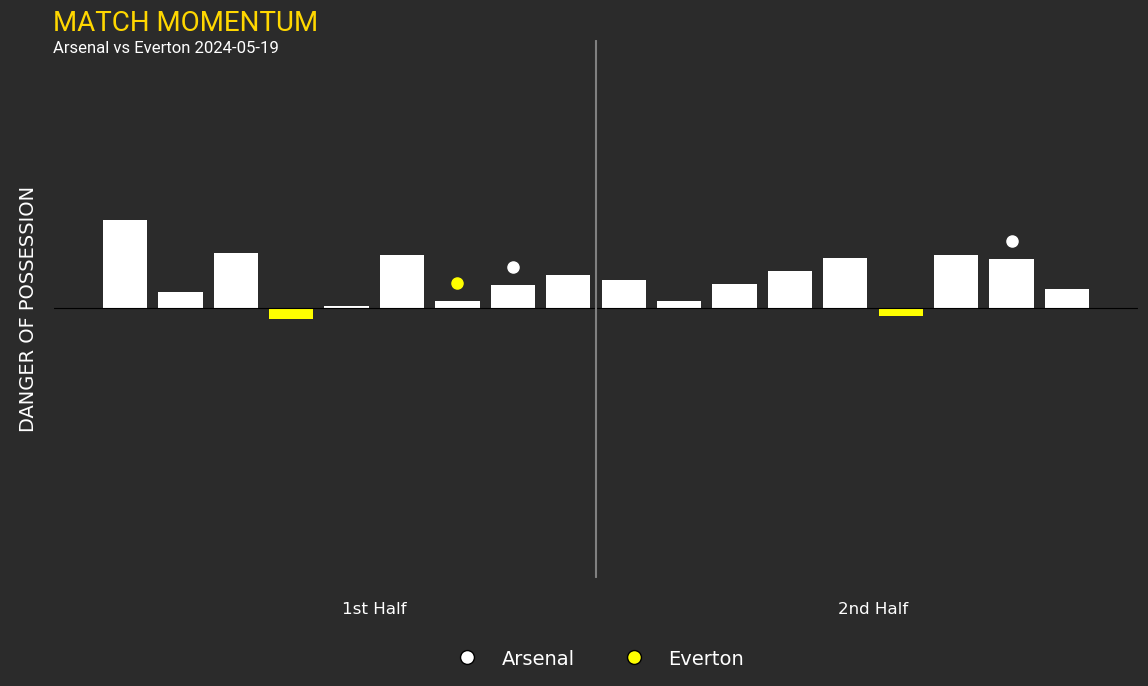

In [42]:
# Concatenate bins from both periods
bin_means['period_bin'] = bin_means['PERIOD_ID'].astype(str) + '-' + bin_means['bins'].astype(str)

# Group goals by bins
df_goals['bins'] = pd.cut(df_goals['NEW_TIME_SECONDS'], bins=bins, labels=labels, include_lowest=True)
goals_binned = df_goals.groupby(['PERIOD_ID', 'bins', 'TEAM_FBREF_ID']).size().reset_index(name='goals')

# Plotting the binned mean xT difference as a bar plot
fig, ax = plt.subplots(figsize=(14, 7))

# Change the background color
fig.patch.set_facecolor('#2B2B2B')
ax.set_facecolor('#2B2B2B')

# Remove the border around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('#2B2B2B')

# Plotting bars with custom colors for positive and negative values
bars = ax.bar(bin_means['period_bin'], bin_means['difference'], color=bin_means['difference'].apply(lambda x: 'white' if x > 0 else 'yellow'))

# Set y-axis limits
ax.set_ylim([-1.5, 1.5])

# Add horizontal line at y=0
ax.axhline(0, color='black', linewidth=0.8)

# Customize the title, labels, and ticks
ax.set_title('MATCH MOMENTUM', color='gold', fontsize=20, fontname='Roboto', loc='left')
fig.text(0.125, 0.86, f'{team1} vs {team2} {datetime_obj}', color='white', fontsize=12, fontname='Roboto')
# ax.set_xlabel('Bins', color='white')
ax.set_ylabel('DANGER OF POSSESSION', color='white', labelpad=-20, size=14)
ax.tick_params(colors='#2B2B2B', which='both', labelcolor='#2B2B2B')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add segregated x-axis labels for "1st Half" and "2nd Half"
halfway_point = len(bin_means['period_bin']) // 2
ax.text(halfway_point / 2, -1.7, '1st Half', horizontalalignment='center', color='white', fontsize=12)
ax.text(halfway_point + halfway_point / 2, -1.7, '2nd Half', horizontalalignment='center', color='white', fontsize=12)
ax.axvline(x=halfway_point - 0.5, color='gray', linestyle='-')

# Add legend with circles
colors = {team1: 'white', team2: 'yellow'}
labels = list(colors.keys())
handles = [plt.Line2D([0], [0], marker='o', color='none', markerfacecolor=colors[label], markersize=10) for label in labels]
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, facecolor='#2B2B2B', edgecolor='none', framealpha=0, fontsize=14, labelcolor='white')

# Plot goal markers
team_colors = {team1_id: 'white', team2_id: 'yellow'}
for i, row in goals_binned.iterrows():
    period_bin = str(row['PERIOD_ID']) + '-' + str(row['bins'])
    bar = bin_means[bin_means['period_bin'] == period_bin].index
    if len(bar) > 0:
        x_pos = bar[0]
        y_pos = bin_means.loc[x_pos, 'difference']
        for goal in range(row['goals']):
            ax.plot(x_pos, y_pos + 0.1 + goal * 0.1, marker='o', color=team_colors[row['TEAM_FBREF_ID']], markersize=8)

plt.show()

In [43]:
in_play_xT = calculate_move_success(df_successful_in_play_events, xt, pitch, bins, False)

In [44]:
in_play_xT

,MATCH_ID,ORIGINAL_EVENT_ID,PERIOD_ID,TIME_SECONDS,NEW_TIME_SECONDS,TEAM_FBREF_ID,PLAYER_WS_ID,x,END_X,y,END_Y,RESULT_ID,ACTION_ID,TYPE_NAME,BODYPART_NAME,PLAYER_FBREF_NAME,TEAM_NAME,DX,DY,move,xt
3,3e33bd98,2.689622e+09,1,8.0,8.0,18bb7c10,361822,34.335,40.425,26.520,34.952,1,3,pass,foot,William Saliba,Arsenal,6.090,8.432,True,0.0
4,3e33bd98,2.689708e+09,2,1573.0,1093.0,18bb7c10,238940,70.350,70.560,45.560,33.728,1,1156,pass,foot,Thomas Partey,Arsenal,0.210,-11.832,True,0.0
5,3e33bd98,2.689658e+09,1,1549.0,1549.0,d3fd31cc,381045,58.485,65.730,52.224,60.588,1,462,pass,foot,Jarrad Branthwaite,Everton,7.245,8.364,True,0.0
6,3e33bd98,2.689715e+09,2,2048.0,1568.0,18bb7c10,113994,100.170,93.450,46.172,38.216,1,1292,pass,foot,Leandro Trossard,Arsenal,-6.720,-7.956,True,0.0
7,3e33bd98,2.689728e+09,2,2877.0,2397.0,18bb7c10,279379,85.995,72.870,57.868,53.788,1,1538,pass,foot,Gabriel Jesus,Arsenal,-13.125,-4.080,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1684,3e33bd98,2.689653e+09,1,1252.0,1252.0,18bb7c10,238940,38.850,66.360,23.528,4.420,1,372,pass,foot,Thomas Partey,Arsenal,27.510,-19.108,True,0.0
1685,3e33bd98,2.689728e+09,2,2845.0,2365.0,18bb7c10,332325,44.100,57.435,57.188,29.784,1,1525,pass,foot,Declan Rice,Arsenal,13.335,-27.404,True,0.0
1686,3e33bd98,2.689637e+09,1,629.0,629.0,18bb7c10,361822,38.430,45.045,14.348,8.568,1,196,pass,foot,William Saliba,Arsenal,6.615,-5.780,True,0.0
1688,3e33bd98,2.689734e+09,2,3413.0,2933.0,18bb7c10,332325,38.955,48.195,22.644,34.136,1,1656,pass,foot,Declan Rice,Arsenal,9.240,11.492,True,0.0


In [45]:
df_cards = fetch_data(cursor, "SELECT * FROM CARDS WHERE MATCH_ID = 1729408")
df_subs = fetch_data(cursor, "SELECT * FROM SUBS WHERE MATCH_ID = 1729408")

In [46]:
teamIds = in_play_xT['TEAM_FBREF_ID'].unique()

In [47]:
in_play_xT.sort_values(by='TIME_SECONDS', ascending=False)

,MATCH_ID,ORIGINAL_EVENT_ID,PERIOD_ID,TIME_SECONDS,NEW_TIME_SECONDS,TEAM_FBREF_ID,PLAYER_WS_ID,x,END_X,y,END_Y,RESULT_ID,ACTION_ID,TYPE_NAME,BODYPART_NAME,PLAYER_FBREF_NAME,TEAM_NAME,DX,DY,move,xt
1323,3e33bd98,2.689735e+09,2,3535.0,3055.0,18bb7c10,273257,69.090,74.445,54.536,11.764,1,1688,pass,foot,Oleksandr Zinchenko,Arsenal,5.355,-42.772,True,0.0
68,3e33bd98,2.689735e+09,2,3533.0,3053.0,18bb7c10,273257,65.520,69.090,59.092,54.536,1,1687,dribble,foot,Oleksandr Zinchenko,Arsenal,3.570,-4.556,True,0.0
457,3e33bd98,NaN,2,3530.5,3050.5,d3fd31cc,131464,28.980,33.390,10.200,6.800,1,1685,dribble,foot,James Tarkowski,Everton,4.410,-3.400,True,0.0
349,3e33bd98,2.689735e+09,2,3522.0,3042.0,18bb7c10,332325,63.420,75.285,50.796,61.540,1,1681,pass,foot,Declan Rice,Arsenal,11.865,10.744,True,0.0
811,3e33bd98,NaN,2,3517.5,3037.5,18bb7c10,332325,40.950,63.420,38.488,50.796,1,1680,dribble,foot,Declan Rice,Arsenal,22.470,12.308,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,3e33bd98,NaN,1,10.0,10.0,18bb7c10,377283,40.425,49.245,34.952,43.384,1,4,dribble,foot,Takehiro Tomiyasu,Arsenal,8.820,8.432,True,0.0
3,3e33bd98,2.689622e+09,1,8.0,8.0,18bb7c10,361822,34.335,40.425,26.520,34.952,1,3,pass,foot,William Saliba,Arsenal,6.090,8.432,True,0.0
109,3e33bd98,2.689622e+09,1,6.0,6.0,18bb7c10,322036,37.275,34.545,19.788,26.044,1,2,pass,foot,Ben White,Arsenal,-2.730,6.256,True,0.0
792,3e33bd98,2.689622e+09,1,3.0,3.0,18bb7c10,276366,31.395,37.170,29.784,19.788,1,1,pass,foot,David Raya,Arsenal,5.775,-9.996,True,0.0


In [48]:
res_dict = {}

for teamId in teamIds:
    mask = in_play_xT['TEAM_FBREF_ID']== teamId
    team_ws_id = team_names[team_names['TEAM_FBREF_ID'] == teamId].TEAM_WS_ID.iloc[0]
    df_cards_oi = df_cards[df_cards['TEAM_WS_ID'] == team_ws_id]
    df_subs_oi = df_subs[df_subs['TEAM_WS_ID'] == team_ws_id]
    df_ = in_play_xT[mask]

    teamName = df_['TEAM_NAME'].unique()[0]

    mask1 = df_cards_oi['CARD_TYPE'].apply(lambda x: x in ["SecondYellow", "Red"])

    first_red_card_minute = (df_cards_oi[mask1].TIME_SECONDS.max()//60)+1
    first_red_card_period = (df_cards_oi[mask1].PERIOD_ID.min())

    first_sub_min = (df_subs_oi.TIME_SECONDS.min()//60)+1
    first_sub_period = (df_subs_oi.PERIOD_ID.min())

    max_minute = (df_[df_['PERIOD_ID'] == 2].NEW_TIME_SECONDS.max()//60)+45+1

    num_minutes = min(first_sub_min, first_red_card_minute, max_minute)
    min_period = min(first_red_card_period, first_sub_period)

    period_max_2ndHalf = True
    if min_period == 1:
        period_max_2ndHalf = False

    df_ = df_.sort_values(['PERIOD_ID','NEW_TIME_SECONDS', 'ORIGINAL_EVENT_ID'])

    passes_df = df_.reset_index().drop('index', axis=1)
    passes_df['playerId'] = passes_df['PLAYER_WS_ID'].astype('Int64')
    passes_df = passes_df[passes_df['playerId'].notnull()]
    passes_df['passRecipientName'] = passes_df['PLAYER_FBREF_NAME'].shift(-1)
    passes_df = passes_df[passes_df['passRecipientName'].notnull()]

    mask1 = passes_df['TYPE_NAME'].apply(lambda x: x in ['pass'])
    passes_df_all = passes_df[mask1]

    if period_max_2ndHalf:
        passes_oi = passes_df_all[passes_df_all['PERIOD_ID'] == 2]
        mask2 = (passes_df_all['PERIOD_ID'] == 1) | (passes_oi['NEW_TIME_SECONDS'] < (num_minutes-45)*60)
        # mask2 = passes_oi['NEW_TIME_SECONDS'] < (num_minutes-45)*60
        players = passes_oi[passes_oi['NEW_TIME_SECONDS'] < (num_minutes-45)*60]['PLAYER_FBREF_NAME'].unique()
    else:
        passes_oi = passes_df_all[passes_df_all['PERIOD_ID'] == 1]
        mask2 = passes_oi['NEW_TIME_SECONDS'] < (num_minutes)*60
        players = passes_oi[passes_oi['NEW_TIME_SECONDS'] < (num_minutes)*60]['PLAYER_FBREF_NAME'].unique()
    
    mask3 = passes_df_all['PLAYER_FBREF_NAME'].apply(lambda x: x in players)
    passes_df_short = passes_df_all[mask2 & mask3]

    mask2 = passes_df_all['PLAYER_FBREF_NAME'] != passes_df_all['passRecipientName']
    mask3 = passes_df_all['RESULT_ID'] == 1

    passes_df_suc = passes_df_all[mask2&mask3]
    passes_df_suc = passes_df_all[mask2]

    if period_max_2ndHalf:
        passes_oi = passes_df_suc[passes_df_suc['PERIOD_ID'] == 2]
        mask2 = (passes_df_suc['PERIOD_ID'] == 1) | (passes_oi['NEW_TIME_SECONDS'] < (num_minutes-45)*60)
        # mask2 = passes_oi['NEW_TIME_SECONDS'] < (num_minutes-45)*60
        players = passes_oi[passes_oi['NEW_TIME_SECONDS'] < (num_minutes-45)*60]['PLAYER_FBREF_NAME'].unique()
    else:
        passes_oi = passes_df_suc[passes_df_suc['PERIOD_ID'] == 1]
        mask2 = passes_oi['NEW_TIME_SECONDS'] < (num_minutes)*60
        players = passes_oi[passes_oi['NEW_TIME_SECONDS'] < (num_minutes)*60]['PLAYER_FBREF_NAME'].unique()
    mask3 = passes_df_suc['PLAYER_FBREF_NAME'].apply(lambda x: x in players) & \
            passes_df_suc['passRecipientName'].apply(lambda x: x in players)
    passes_df_suc_short = passes_df_suc[mask2&mask3]

    print('team: ',teamName)
    print('passes: ', passes_df_all.shape[0])
    print('suc passes: ', passes_df_suc.shape[0])
    print('suc short passes: ', passes_df_suc_short.shape[0])
    print('last minute: min(first red / substitution / end game) = ', num_minutes)
    
    print('suc passes befor last minute: ', passes_df_short.shape[0])
    print('\n')
    
    res_dict[teamId] = {}
    
    res_dict[teamId]['passes_df_all'] = passes_df_all
    res_dict[teamId]['passes_df_short'] = passes_df_short
    res_dict[teamId]['passes_df_suc'] = passes_df_suc
    res_dict[teamId]['passes_df_suc_short'] = passes_df_suc_short
    res_dict[teamId]['minutes'] = num_minutes


team:  Arsenal
passes:  553
suc passes:  546
suc short passes:  340
last minute: min(first red / substitution / end game) =  59.0
suc passes befor last minute:  346


team:  Everton
passes:  208
suc passes:  203
suc short passes:  184
last minute: min(first red / substitution / end game) =  75.0
suc passes befor last minute:  187




In [49]:
var = 'PLAYER_FBREF_NAME'
var2 = 'passRecipientName'

for teamId in teamIds:

    passes_df_all = res_dict[teamId]['passes_df_all']
    passes_df_suc = res_dict[teamId]['passes_df_suc']
    passes_df_short = res_dict[teamId]['passes_df_short']
    passes_df_suc_short = res_dict[teamId]['passes_df_suc_short']
    
    player_position = passes_df_short.groupby(var).agg({'x': ['median'], 'y': ['median']})

    player_position.columns = ['x', 'y']
    player_position.index.name = 'PLAYER_FBREF_NAME'
    player_position.index = player_position.index.astype(str)

    player_pass_count_all = passes_df_all.groupby(var).agg({'playerId':'count'}).rename(columns={'playerId':'num_passes_all'})
    player_pass_count_suc = passes_df_suc.groupby(var).agg({'playerId':'count'}).rename(columns={'playerId':'num_passes'})
    player_pass_count_suc_short = passes_df_suc_short.groupby(var).agg({'playerId':'count'}).rename(columns={'playerId':'num_passes2'})
    player_pass_count = player_pass_count_all.join(player_pass_count_suc).join(player_pass_count_suc_short)
    
        
    passes_df_all["pair_key"] = passes_df_all.apply(lambda x: "_".join([str(x[var]), str(x[var2])]), axis=1)
    passes_df_suc["pair_key"] = passes_df_suc.apply(lambda x: "_".join([str(x[var]), str(x[var2])]), axis=1)
    passes_df_suc_short["pair_key"] = passes_df_suc_short.apply(lambda x: "_".join([str(x[var]), str(x[var2])]), axis=1)


    
    pair_pass_count_all = passes_df_all.groupby('pair_key').agg({'playerId':'count'}).rename(columns={'playerId':'num_passes_all'})
    pair_pass_count_suc = passes_df_suc.groupby('pair_key').agg({'playerId':'count'}).rename(columns={'playerId':'num_passes'})
    pair_pass_count_suc_short = passes_df_suc_short.groupby('pair_key').agg({'playerId':'count'}).rename(columns={'playerId':'num_passes2'})
    pair_pass_count = pair_pass_count_all.join(pair_pass_count_suc).join(pair_pass_count_suc_short)
    
    
    
    player_pass_value_suc = (passes_df_suc.groupby(var)
                                 .agg({'xt':'sum'})
                                 .round(3)
                                 .rename(columns={'xt':'pass_value'}))
    player_pass_value_suc_short = (passes_df_suc_short.groupby(var)
                                 .agg({'xt':'sum'})
                                 .round(3)
                                 .rename(columns={'xt':'pass_value2'}))
    player_pass_value = player_pass_value_suc.join(player_pass_value_suc_short)

    
    
                
    pair_pass_value_suc = (passes_df_suc.groupby(['pair_key'])
                               .agg({'xt':'sum'})
                               .round(3)
                               .rename(columns={'xt':'pass_value'}))
    pair_pass_value_suc_short = (passes_df_suc_short.groupby(['pair_key'])
                           .agg({'xt':'sum'})
                           .round(3)
                           .rename(columns={'xt':'pass_value2'}))
    pair_pass_value = pair_pass_value_suc.join(pair_pass_value_suc_short)

    
    player_position['z'] = player_position['x']
    player_position['x'] = player_position['y']
    player_position['y'] = player_position['z']
    
    res_dict[teamId]['player_position'] = player_position
    res_dict[teamId]['player_pass_count'] = player_pass_count
    res_dict[teamId]['pair_pass_count'] = pair_pass_count
    res_dict[teamId]['player_pass_value'] = player_pass_value
    res_dict[teamId]['pair_pass_value'] = pair_pass_value

C:\Users\ksbha\AppData\Local\Temp\ipykernel_34364\835733967.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df_suc["pair_key"] = passes_df_suc.apply(lambda x: "_".join([str(x[var]), str(x[var2])]), axis=1)
C:\Users\ksbha\AppData\Local\Temp\ipykernel_34364\835733967.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df_suc_short["pair_key"] = passes_df_suc_short.apply(lambda x: "_".join([str(x[var]), str(x[var2])]), axis=1)
C:\Users\ksbha\AppData\Local\Temp\ipykernel_34364\835733967.py:2

In [50]:
res_dict['18bb7c10'].keys()

dict_keys(['passes_df_all', 'passes_df_short', 'passes_df_suc', 'passes_df_suc_short', 'minutes', 'player_position', 'player_pass_count', 'pair_pass_count', 'player_pass_value', 'pair_pass_value'])

In [52]:
import os
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from scipy.stats import binned_statistic_2d
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import RegularPolygon, Arrow, ArrowStyle,FancyArrowPatch, Circle,FancyArrow
from mplsoccer.pitch import Pitch, VerticalPitch
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from highlight_text import fig_text, ax_text


import warnings
warnings.filterwarnings("ignore")

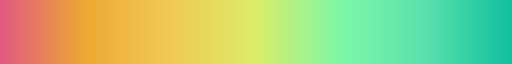

In [53]:
nodes_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#E15A82',
                                                               '#EEA934',
                                                               '#F1CA56',
                                                               '#DCED69',
                                                               '#7FF7A8',
                                                               '#5AE1AC',
                                                               '#11C0A1'
                                                               
                                                                       
                                                            ])
nodes_cmap

In [54]:
node_cmap = cm.get_cmap(nodes_cmap)

norm = Normalize(vmin=0, vmax=1)
node_color1 = node_cmap(norm(0)) 
node_color2 = node_cmap(norm(0.25)) 
node_color3 = node_cmap(norm(0.5)) 
node_color4 = node_cmap(norm(0.75)) 
node_color5 = node_cmap(norm(1)) 

In [55]:
def change_range(value, old_range, new_range):

    new_value = ((value-old_range[0]) / (old_range[1]-old_range[0])) * (new_range[1]-new_range[0]) + new_range[0]
    
    if new_value >= new_range[1]:
        return new_range[1]
    elif new_value <= new_range[0]:
        return new_range[0]
    else:
        return new_value

In [56]:
#nodes
min_node_size = 5
max_node_size = 35

max_player_count = 88
min_player_count = 1

max_player_value = 0.36
min_player_value = 0.01

#font
font_size = 8
font_color = 'black'

#edges arrow

min_edge_width = 0.5
max_edge_width = 5

head_length = 0.3
head_width = 0.1

max_pair_count = 16
min_pair_count = 1

min_pair_value  = 0.01
max_pair_value = 0.085

min_passes = 5

In [63]:
player_stats

,num_passes_all,num_passes,num_passes2,pass_value,pass_value2,marker_size
PLAYER_FBREF_NAME,,,,,,
Abdoulaye Doucouré,24,24,23,0.0,0.0,12.931034
Amadou Onana,26,24,21,0.0,0.0,12.931034
Ashley Young,19,19,18,0.0,0.0,11.206897
Dominic Calvert-Lewin,7,7,7,0.0,0.0,7.068966
Dwight McNeil,29,28,23,0.0,0.0,14.310345
Idrissa Gana Gueye,33,33,28,0.0,0.0,16.034483
James Garner,14,13,12,0.0,0.0,9.137931
James Tarkowski,13,13,13,0.0,0.0,9.137931
Jarrad Branthwaite,19,19,18,0.0,0.0,11.206897


In [72]:
mask

array(['Thomas Partey', 'James Garner', 'Ben White', 'Takehiro Tomiyasu',
       'Martin Ødegaard', 'Idrissa Gana Gueye', 'Amadou Onana',
       'Jordan Pickford', 'Declan Rice', 'Gabriel Martinelli',
       'William Saliba', 'Ashley Young', 'Leandro Trossard',
       'Dwight McNeil', 'Gabriel Magalhães', 'James Tarkowski',
       'David Raya', 'Jarrad Branthwaite', 'Abdoulaye Doucouré',
       'Dominic Calvert-Lewin', 'Séamus Coleman', 'Kai Havertz'],
      dtype=object)

In [83]:
minutes_

75.0

                    num_passes_all  num_passes  num_passes2  pass_value  \
PLAYER_FBREF_NAME                                                         
Ben White                       54          53           50         0.0   
David Raya                      15          15            8         0.0   
Declan Rice                     42          42           15         0.0   
Gabriel Magalhães               37          35           35         0.0   
Gabriel Martinelli              33          33           25         0.0   
Kai Havertz                     18          17           11         0.0   
Leandro Trossard                25          25           16         0.0   
Martin Ødegaard                 51          50           28         0.0   
Takehiro Tomiyasu               41          40           31         0.0   
Thomas Partey                   74          73           62         0.0   
William Saliba                  85          85           59         0.0   

                    pass

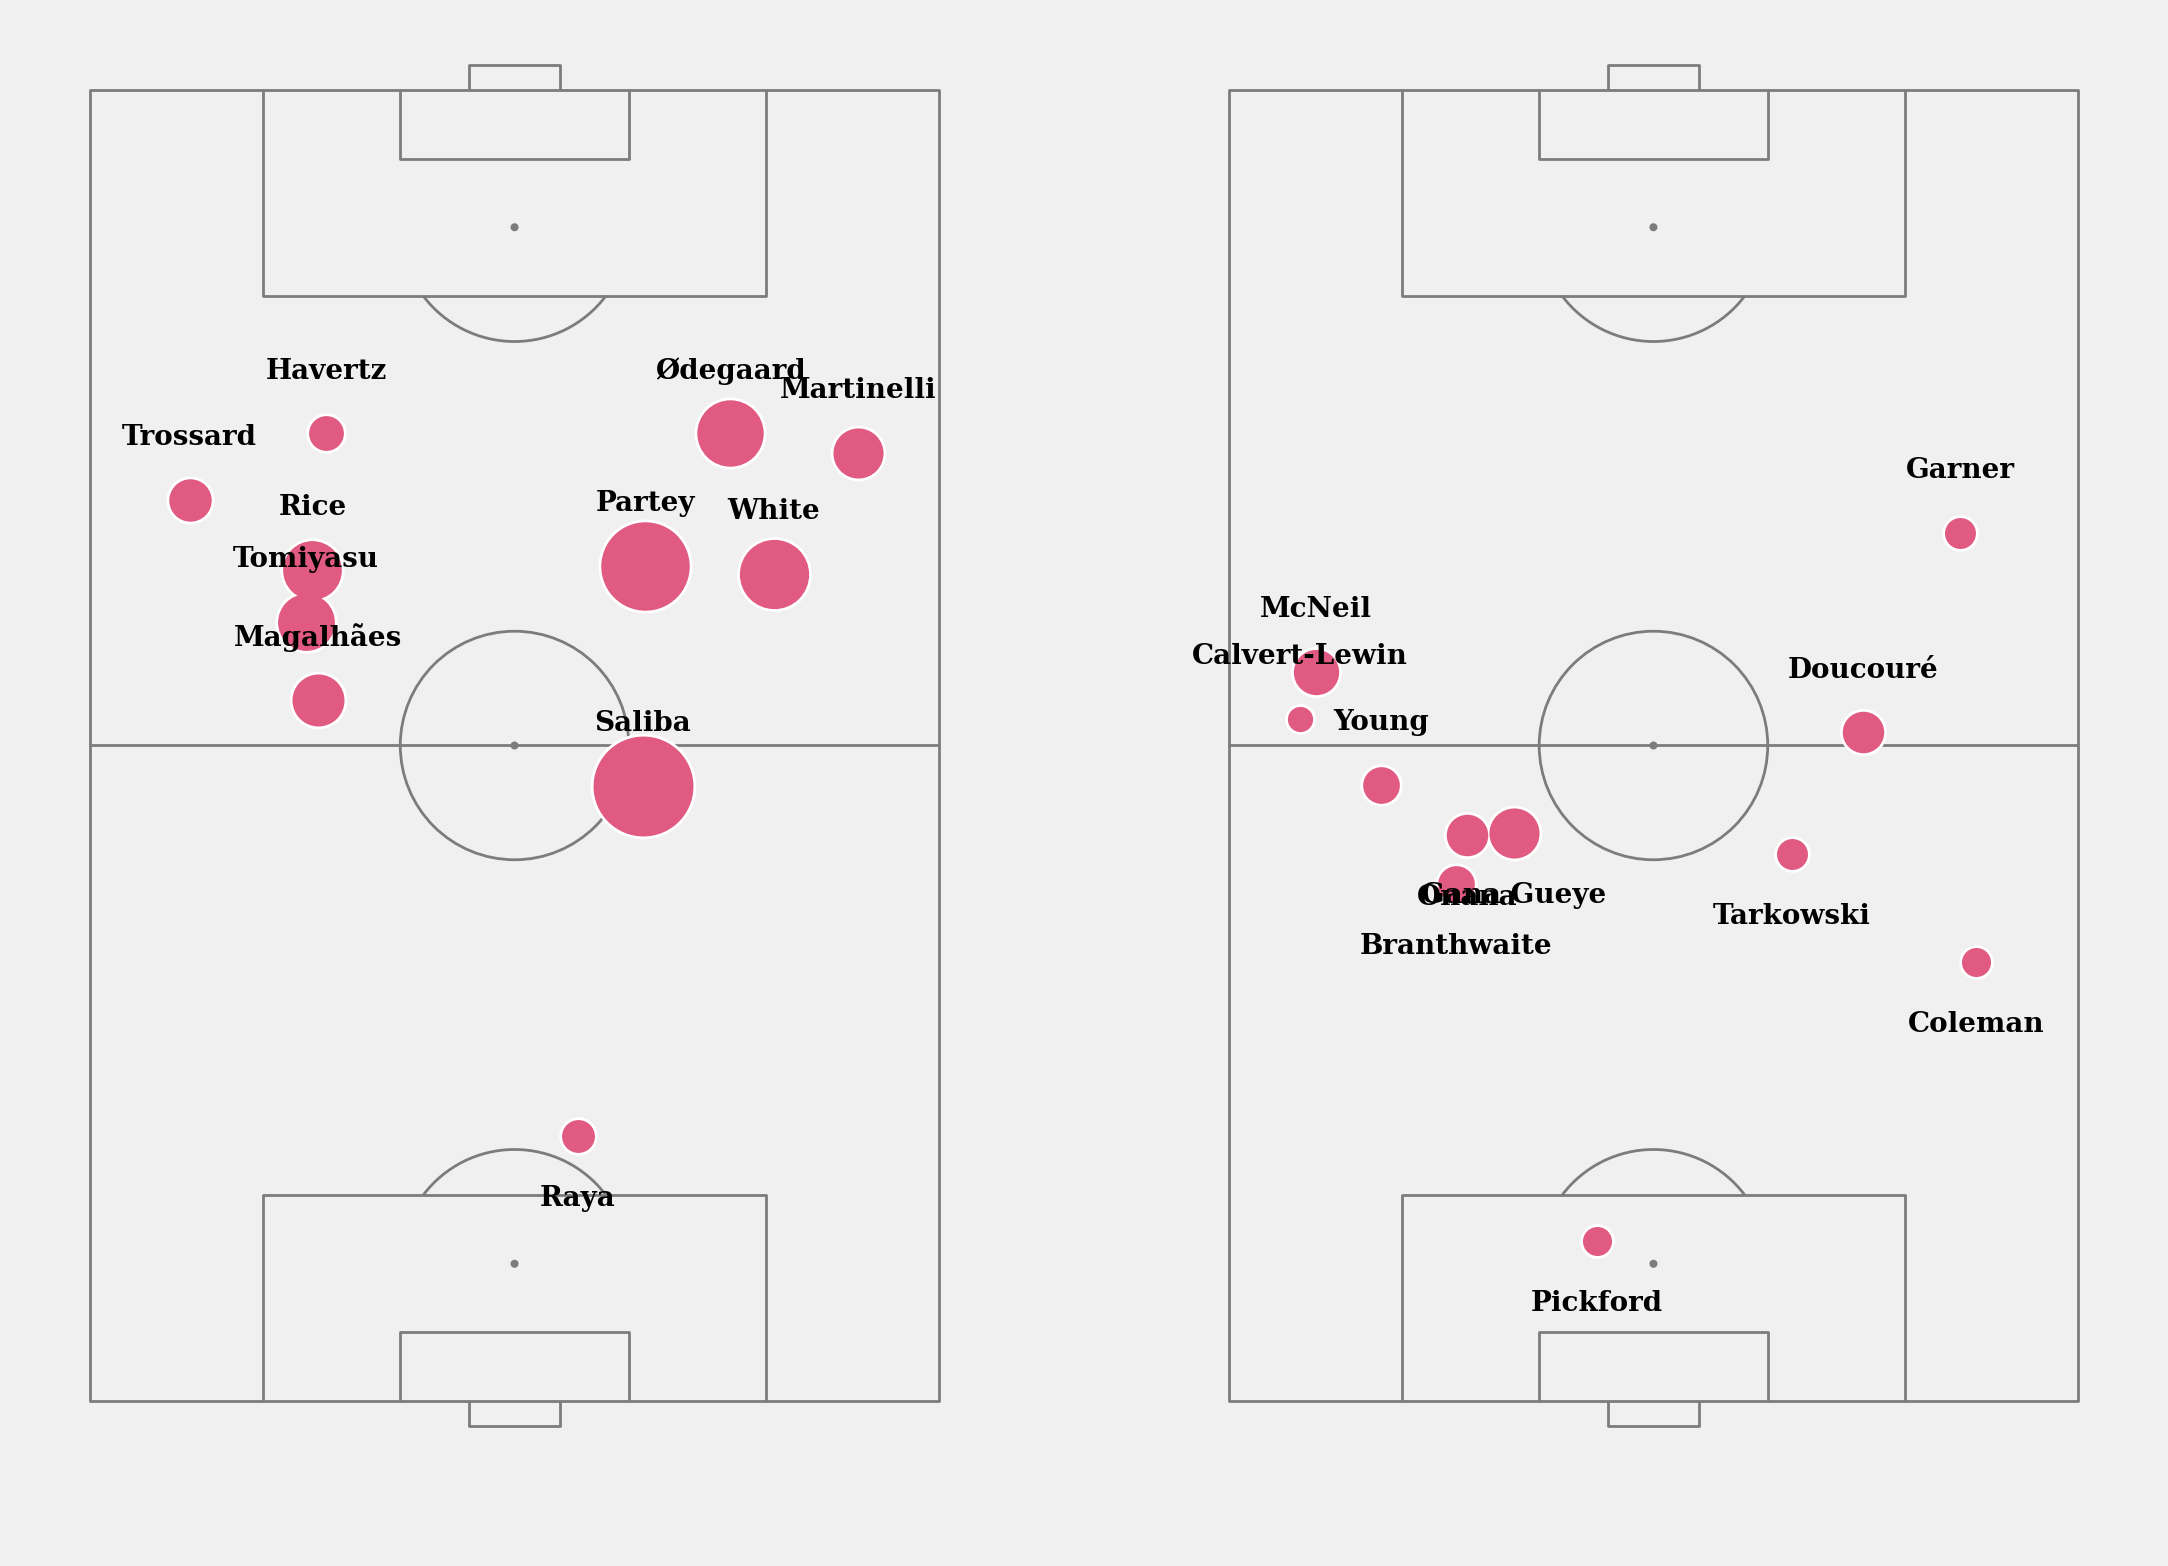

In [85]:
plt.style.use('fivethirtyeight')

fig,ax = plt.subplots(1,2,figsize=(6,6), dpi=400)

teamId_home = teamIds[0]
teamId_away = teamIds[1]

for i, teamid in enumerate([teamId_home, teamId_away]):    

    #define dataframes
    position = res_dict[teamid]['player_position']
    player_pass_count = res_dict[teamid]['player_pass_count']
    pair_pass_count = res_dict[teamid]['pair_pass_count']
    player_pass_value = res_dict[teamid]['player_pass_value']
    pair_pass_value = res_dict[teamid]['pair_pass_value']
    minutes_ = res_dict[teamid]['minutes']

    pitch = VerticalPitch(pitch_type='uefa', 
                          line_color='#7c7c7c',
                          goal_type='box',
                          linewidth=0.5,
                        pad_bottom=10)
    
    #plot vertical pitches
    pitch.draw(ax=ax[i], constrained_layout=False, tight_layout=False)
    
    # Step 1: processing for plotting edges
    pair_stats = pd.merge(pair_pass_count, pair_pass_value, left_index=True, right_index=True)
    pair_stats = pair_stats.sort_values('num_passes',ascending=False)
    pair_stats2 = pair_stats[pair_stats['num_passes'] >= min_passes]
    
    # Step 2: processing for plotting nodes
    player_stats = pd.merge(player_pass_count, player_pass_value, left_index=True, right_index=True)
    
    data_passy = in_play_xT[in_play_xT['TEAM_FBREF_ID'] == teamid]

    #FILTER first 11 players
    if minutes_ <= 45:
        
        players_ = data_passy[(data_passy['PERIOD_ID'] == 1) & (data_passy['NEW_TIME_SECONDS'] < (minutes_)*60)]['PLAYER_FBREF_NAME'].unique()
    else:
        players_ = data_passy[(data_passy['PERIOD_ID'] == 2) & (data_passy['NEW_TIME_SECONDS'] < (minutes_-46)*60)]['PLAYER_FBREF_NAME'].unique()

    # players_ = list(set(in_play_xT[mask]['PLAYER_FBREF_NAME'].dropna()))
        
    # mask = in_play_xT['minute'] < minutes_
    # players_ = list(set(in_play_xT[mask]['playerName'].dropna()))
    
    mask_ = player_stats.index.map(lambda x: x in players_)
    player_stats = player_stats.loc[mask_]
    
    mask_ = pair_stats2.index.map(lambda x: (x.split('_')[0] in players_) &  (x.split('_')[1] in players_))
    pair_stats2 = pair_stats2[mask_]
    
    ind = position.index.map(lambda x: x in players_)
    position = position.loc[ind]
    
    # Step 3: plotting nodes
    print(player_stats)
    for var, row in player_stats.iterrows():
        player_x = position.loc[var]["x"]
        player_y = position.loc[var]["y"]

        num_passes = row["num_passes"]
        pass_value = row["pass_value"]

        marker_size = change_range(num_passes, (min_player_count, max_player_count), (min_node_size, max_node_size))
        norm = Normalize(vmin=min_player_value, vmax=max_player_value)
        
        node_color = node_cmap(norm(pass_value)) 

        ax[i].plot(player_x, player_y, '.', color=node_color, markersize=marker_size, zorder=5)
        ax[i].plot(player_x, player_y, '.', markersize=marker_size+2, zorder=4, color='white')

        var_ = ' '.join(var.split(' ')[1:]) if len(var.split(' ')) > 1 else var
        ax[i].annotate(var_, xy=(player_x, player_y+5 if player_y > 48 else player_y - 5), ha="center", va="center", zorder=7,
                    fontsize=5, 
                    color = 'black',
                    font = 'serif',
                    weight='heavy')

        player_stats.loc[var, 'marker_size'] = marker_size


#     # Step 4: ploting edges  
#     for pair_key, row in pair_stats2.iterrows():
#         player1, player2 = pair_key.split("_")

#         player1_x = position.loc[player1]["x"]
#         player1_y = position.loc[player1]["y"]

#         player2_x = position.loc[player2]["x"]
#         player2_y = position.loc[player2]["y"]

#         num_passes = row["num_passes"]
#         pass_value = row["pass_value"]

#         line_width = change_range(num_passes, (min_pair_count, max_pair_count), (min_edge_width, max_edge_width))
#         alpha = change_range(pass_value, (min_player_value, max_player_value), (0.4, 1))

#         norm = Normalize(vmin=min_pair_value, vmax=max_pair_value)
#         edge_cmap = cm.get_cmap(nodes_cmap)
#         edge_color = edge_cmap(norm(pass_value))

#         x = player1_x
#         y = player1_y
#         dx = player2_x-player1_x
#         dy = player2_y-player1_y
#         rel = 68/105
#         shift_x = 2
#         shift_y = shift_x*rel

#         slope = round(abs((player2_y - player1_y)*105/100 / (player2_x - player1_x)*68/100),1)

#         mutation_scale = 1
#         if (slope > 0.5):
#             if dy > 0:
#                 ax[i].annotate("", xy=(x+dx+shift_x, y+dy), xytext=(x+shift_x, y),zorder=2,
#                         arrowprops=dict(arrowstyle=f'->, head_length = {head_length}, head_width={head_width}',
#                                         color=tuple([alpha if n == 3 else i for n, i in enumerate(edge_color)]),
#                                         fc = 'blue',
#                                         lw=line_width,
#                                         shrinkB=player_stats.loc[player2, 'marker_size']/5))
                
                
#             elif dy <= 0:
#                 ax[i].annotate("", xy=(x+dx-shift_x, y+dy), xytext=(x-shift_x, y),zorder=2,
#                         arrowprops=dict(arrowstyle=f'->, head_length = {head_length}, head_width={head_width}',
#                                         color=tuple([alpha if n == 3 else i for n, i in enumerate(edge_color)]),
#                                         fc = 'blue',
#                                         lw=line_width,
#                                         shrinkB=player_stats.loc[player2, 'marker_size']/5))
                
#         elif (slope <= 0.5) & (slope >=0):
#             if dx > 0:
# #                 print(2)

#                 ax[i].annotate( "", xy=(x+dx, y+dy-shift_y), xytext=(x, y-shift_y),zorder=2,
#                         arrowprops=dict(arrowstyle=f'->, head_length = {head_length}, head_width={head_width}',
#                                         color=tuple([alpha if n == 3 else i for n, i in enumerate(edge_color)]),
#                                         fc = 'blue',
#                                         lw=line_width,
#                                         shrinkB=player_stats.loc[player2, 'marker_size']/5))

#             elif dx <= 0:

#                 ax[i].annotate("", xy=(x+dx, y+dy+shift_y), xytext=(x, y+shift_y),zorder=2,
#                         arrowprops=dict(arrowstyle=f'->, head_length = {head_length}, head_width={head_width}',
#                                         color=tuple([alpha if n == 3 else i for n, i in enumerate(edge_color)]),
#                                         fc = 'blue',
#                                         lw=line_width,
#                                         shrinkB=player_stats.loc[player2, 'marker_size']/5))
#         else:
#             print(1)